## 데이터 군집

이 노트북에서 군집(clustering)을 간단히 소개하고 umap을 사용해 군집의 성능을 조사하는 방법을 알아 보겠습니다. 이 노트북은 사이킷런의 군집 [튜토리얼](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)을 참고했습니다.

먼저 수동 방법을 알아 보고 그다음 실루엣 점수와 클러스터 크기를 사용해 자동 방법을 알아 보겠습니다.

먼저 데이터를 로드하고 변환한 다음 임베딩합니다.

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import format_raw_df, get_split_by_author, add_text_features_to_df, get_vectorized_series, train_vectorizer

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = add_text_features_to_df(df.loc[df["is_question"]].copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

In [2]:
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat", "lemmatizer"])
train_author["vectors"] = train_author["full_text"].apply(lambda x: nlp(x).vector)
vectorized_features= np.vstack(train_author["vectors"])

In [3]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

[K 평균](https://en.wikipedia.org/wiki/K-means_clustering)을 사용해 데이터를 클러스터링해 보죠. K 평균을 사용하려면 원하는 클러스터 개수를 매개변수로 지정해야 합니다. 3개의 클러스터로 시작해 보겠습니다. 클러스터마다 다른 색깔을 입혀 UMAP으로 결과를 시각화합니다.

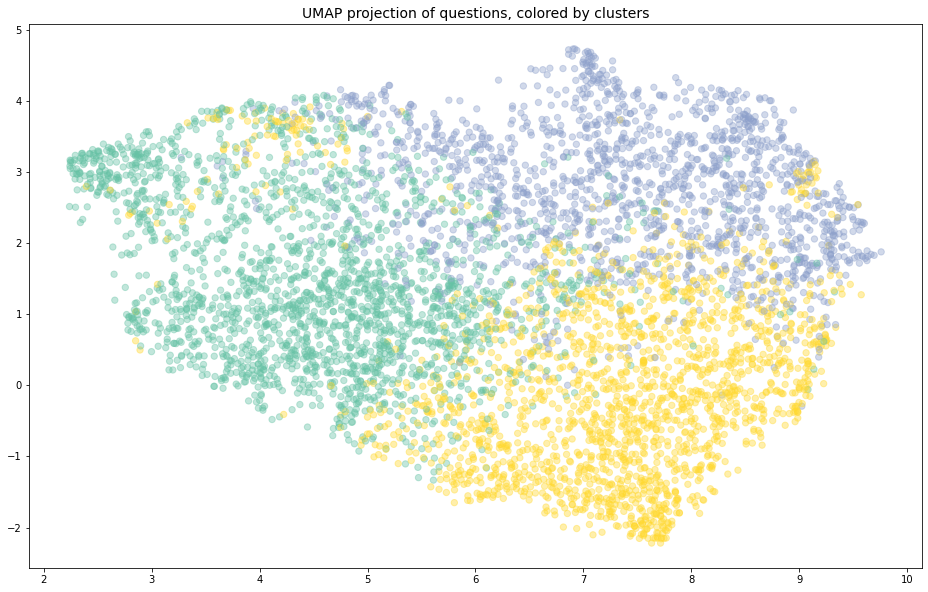

In [4]:
# 클러스터 개수와 컬러맵을 선택합니다
n_clusters=3
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))


# 벡터화된 특성에 군집 알고리즘을 훈련합니다
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# 차원 축소된 특성을 2D 평면에 출력합니다
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14);
plt.savefig('../images/bmlpa_figures/ch04-10.png', dpi=300)

#### 번역서 부록

KMeans 알고리즘을 사용할 때 각 샘플을 클러스터의 중심까지의 거리로 표현할 수 있습니다. `KMeans` 클래스의 `trasnform()` 메서드에서 이를 수행합니다. 여기에서 클러스터 개수는 3개 이므로 반환된 데이터의 특성 개수도 3개가 됩니다. 클러스터 중심까지 거리를 사용해 시각화를 하면 종종 더 나은 결과를 보여줍니다.

아래 코드는 `KMeans` 클래스의 `transform()` 메서드로 `vectorized_features`를 `transformed_features`로 변환한 후 UMAP으로 시각화하는 예입니다. 

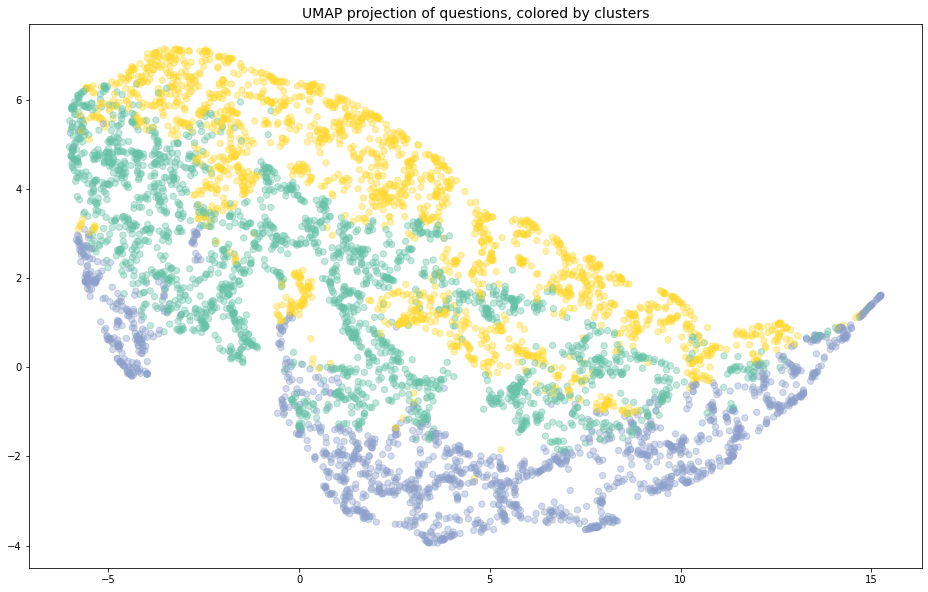

In [5]:
transformed_features = clus.transform(vectorized_features)

umap_features = umap_embedder.fit_transform(transformed_features)

# Plot the dimentionality reduced features on a 2D plane
fig = plt.figure(figsize=(16, 10))
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14);
plt.savefig('../images/bmlpa_figures/ch04-10A.png', dpi=300)

---

이 그래프에서는 올바른 클러스터 개수를 선택했는지 확실하지 않습니다. 어떤 영역은 특정 클러스터에 할당된 것 같지만 그렇지 않고 분할된 영역도 있습니다. 클러스터 개수를 바꾸어 시도해 보고 umap과 [실루엣 점수](https://en.wikipedia.org/wiki/Silhouette_(clustering))를 사용해 그래프를 그려 보겠습니다.

For n_clusters = 2 The average silhouette_score is : 0.16982274
(2, 300)
For n_clusters = 3 The average silhouette_score is : 0.07567544
(3, 300)
For n_clusters = 4 The average silhouette_score is : 0.06365539
(4, 300)
For n_clusters = 5 The average silhouette_score is : 0.05683346
(5, 300)
For n_clusters = 6 The average silhouette_score is : 0.034223337
(6, 300)


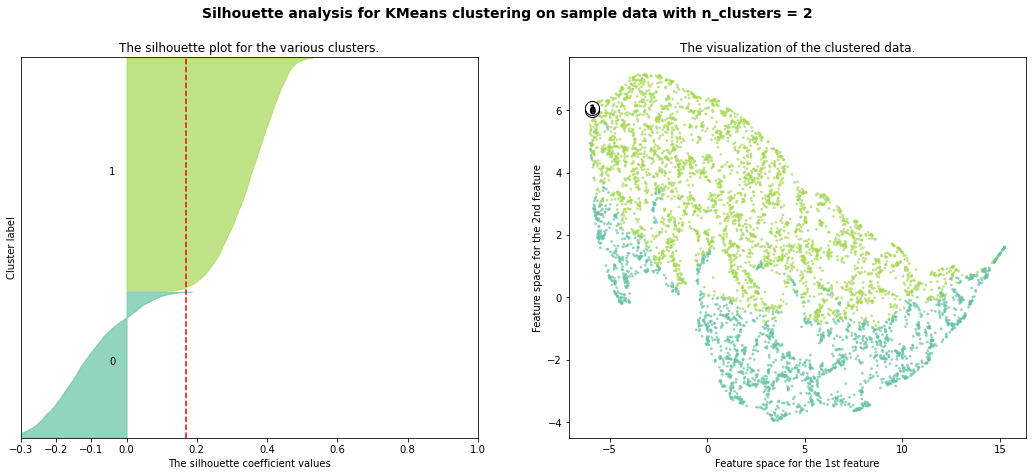

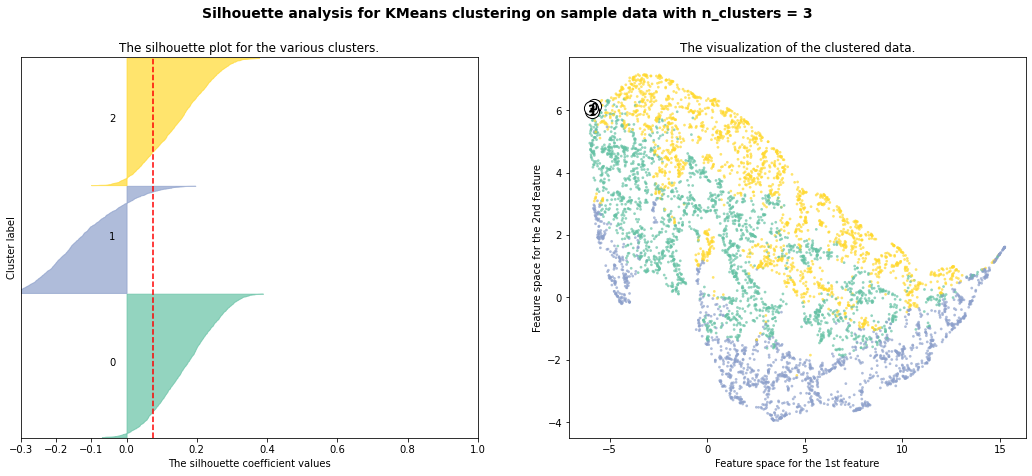

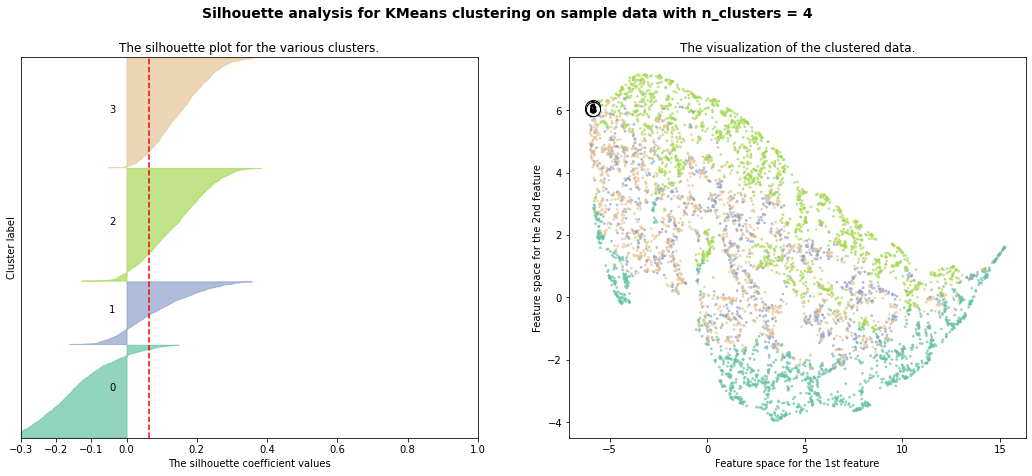

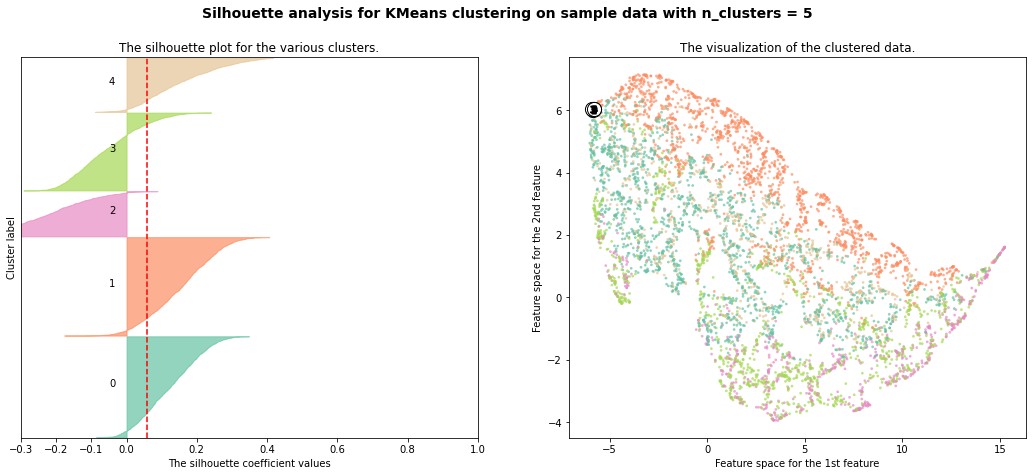

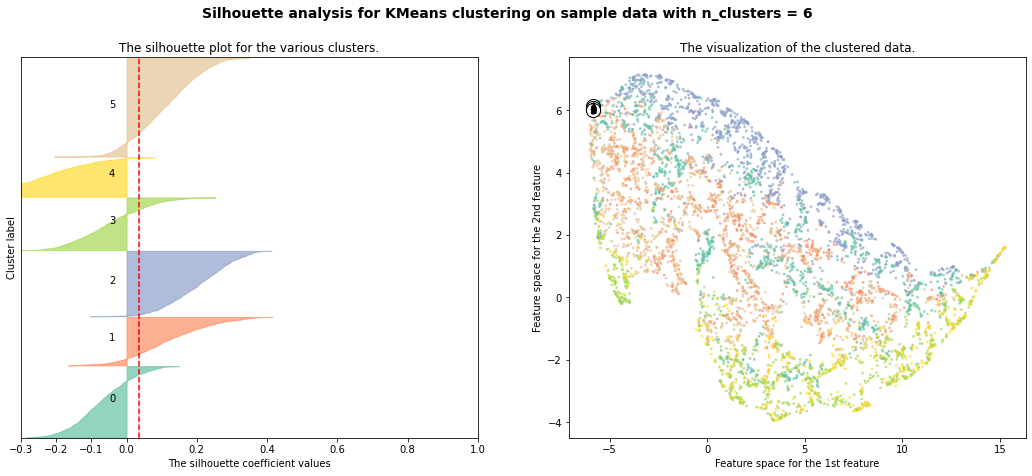

In [6]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
range_n_clusters = [2, 3, 4, 5, 6]

to_clus = vectorized_features

for n_clusters in range_n_clusters:
    # 1행 2열의 서브플롯을 만듭니다
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 첫 번째 서브플롯은 실루엣 그래프입니다
    # 실루엣 계수는 -1~1 사이이지만 이 예에서는 모두 [-0.1, 1] 사이에 있습니다
    ax1.set_xlim([-.3, .4])
    # (n_clusters+1)*10는 클러스터 실루엣 그래프 사이의 공백을 위한 것입니다
    ax1.set_ylim([0, len(to_clus) + (n_clusters + 1) * 10])

    # n_cluster와 재현을 위한 random_state를 지정하여 K 평균 객체를 초기화합니다
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(to_clus)

    # silhouette_score 함수는 모든 샘플에 대한 평균을 반환합니다
    # 이를 통해 만들어진 클러스터의 조밀함과 차별성을 판단합니다
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric='cosine')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # 각 샘플에 대한 실루엣 점수를 계산합니다
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # 클러스터 i에 속한 샘플의 실루엣 점수를 찾아 정렬합니다
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # 실루엣 그래프에 클러스터 번호로 레이블을 매깁니다
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # 다음 그래프를 위해 새로운 y_lower를 계산합니다
        y_lower = y_upper + 10  # 샘플일 0개일 경우를 위해 10을 더함

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # 평균 실루엣 점수로 수직선을 그립니다
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # y축 레이블을 삭제합니다
    ax1.set_xticks([-0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2차원 평면에 실제 클러스터를 그립니다
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_features[:, 0], umap_features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # 클러스터에 레이블을 부여합니다
    centerss = clusterer.cluster_centers_
    print(centerss.shape)
    centers = umap_embedder.transform(centerss)
    # 클러스터 중심에 하얀 원을 그립니다
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

하나의 실루엣 점수는 군집 품질을 평가하기에는 너무 고수준의 지표입니다. 조금 더 세밀한 정보를 얻기 위해서 개별 데이터 포인트의 실루엣 점수를 클러스터별로 그릴 수 있습니다.

완벽한 상황에서 클러스터 안의 대부분 포인트는 1에 가까운 실루엣 점수를 가질 것입니다. 이 예제에서는 최적의 클러스터는 없는 것 같습니다. 하지만 세 개와 네 개의 클러스터는 대부분의 포인트가 양수 점수를 가진 실루엣 그래프를 그립니다. 군집에 대해 더 자세히 알고 싶다면 DBSCAN이나 MeanShift 같은 다른 알고리즘을 살펴 보세요(사이킷런의 [군집 알고리즘](https://scikit-learn.org/stable/modules/clustering.html)).